# UNet сегментация

## Kaggle датасет

In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

from skimage import data

from PIL import Image

from tqdm import trange, tqdm

from sklearn.model_selection import train_test_split

In [2]:
import os

dataset_path = "/kaggle/input/swir-products-merged2/swir_products_merged2"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")

dataset_path_test = "/kaggle/input/swir-products-merged2/swir_products_merged2"
test_images_path = os.path.join(dataset_path_test, "images/test")
test_masks_path = os.path.join(dataset_path_test, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])

Train Images: 678
Train Masks: 226
Test Images: 108
Test Masks: 36

Примеры файлов (Train Images): ['349_1050.jpg', '122_800.jpg', '345_1050.jpg', '072_800.jpg', '107_800.jpg']
Примеры файлов (Train Masks): ['173.png', '248.png', '038.png', '069.png', '340.png']


## PyTorch датасет и даталоадер

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as T


class MultiChannelSingleMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, wavelengths=(800, 1050, 1550), transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.wavelengths = wavelengths
        self.transform = transform
        self.img_size = img_size

        # Собираем все файлы изображений и извлекаем уникальные ID
        all_files = os.listdir(images_dir)
        
        # Фильтруем только те файлы, которые являются изображениями
        image_ids = sorted(set(f.split('_')[0] for f in all_files if f.endswith(".jpg")))

        # Проверка, если нет файлов, то выводим ошибку
        if not image_ids:
            print(f"Нет файлов изображений в директории: {images_dir}")
        else:
            print(f"Найдены следующие ID изображений: {image_ids}")

        # Подготовим список ID изображений
        self.image_ids = image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Загружаем 3 изображения по длинам волн
        image = []
        for wl in self.wavelengths:
            image_path = os.path.join(self.images_dir, f"{image_id}_{wl}.jpg")
            if not os.path.exists(image_path):
                print(f"Изображение не найдено: {image_path}")
                continue  # Пропускаем файл, если его нет
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype(np.float32) / 255.0
            image.append(img)
        
        # Если не все каналы загружены, пропускаем этот ID
        if len(image) != len(self.wavelengths):
            print(f"Ошибка: не удалось загрузить все каналы для ID {image_id}")
            return None  # Если не удалось загрузить все каналы, возвращаем None

        image = np.stack(image, axis=-1)  # [H, W, 3]

        # Загружаем маску (одну для всех)
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")
        if not os.path.exists(mask_path):
            print(f"Маска не найдена: {mask_path}")
            return None  # Если маска не найдена, возвращаем None
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        
        # Ресайз маски до 512x512
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # Применяем аугментации, если есть
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # В PyTorch: [C, H, W]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [3, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # [H, W], где 0 — фон, 1 — дефект

        return image, mask




train_dataset = MultiChannelSingleMaskDataset(train_images_path, train_masks_path, img_size=512)

# первый элемент:
sample_img, sample_mask = train_dataset[0]

if sample_img is not None and sample_mask is not None:
    print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
    print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
    print(f"Классы в маске: {torch.unique(sample_mask)}")
else:
    print("Ошибка при загрузке данных")


Найдены следующие ID изображений: ['034', '035', '036', '037', '038', '044', '047', '048', '049', '050', '051', '053', '054', '055', '056', '057', '058', '059', '060', '061', '063', '064', '065', '068', '069', '070', '072', '073', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '086', '087', '088', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '114', '115', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '131', '132', '133', '134', '136', '137', '138', '139', '141', '142', '143', '144', '145', '146', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '167', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199',

In [ ]:
# длина датасета
print(f"Размер датасета: {len(train_dataset)}")

sample_img, sample_mask = train_dataset[217]

# Проверим, что изображение и маска загружены
if sample_img is not None and sample_mask is not None:
    print(f"Форма изображения: {sample_img.shape}")  # Ожидаем [3, 512, 512]
    print(f"Форма маски: {sample_mask.shape}")        # Ожидаем [512, 512]
    print(f"Классы в маске: {torch.unique(sample_mask)}")
else:
    print("Ошибка при загрузке данных")

# 3. Для визуализации одного примера
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    image = image.permute(1, 2, 0).numpy()  # Преобразуем изображение в [H, W, C]
    mask = mask.numpy()
    
    # Создаем подграфики для изображения и маски
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Отображаем изображение
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    # Отображаем маску
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.show()

# Отображаем первый пример
if sample_img is not None and sample_mask is not None:
    show_image_and_mask(sample_img, sample_mask)


Размер датасета: 226
Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


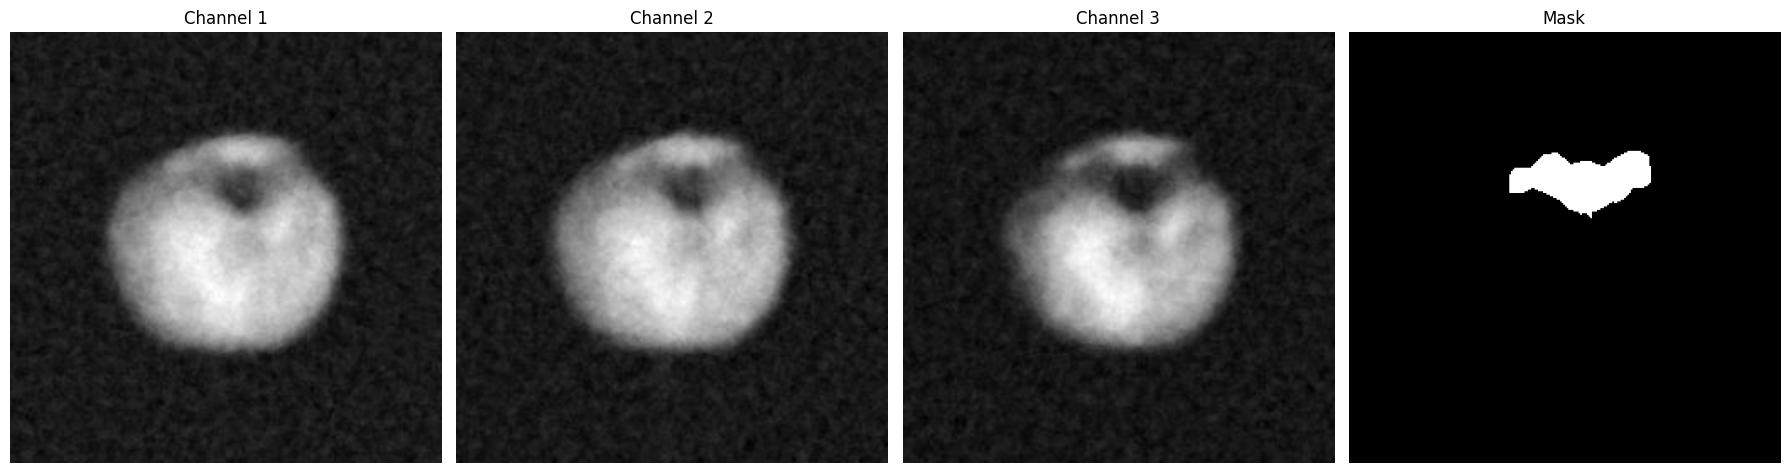

In [5]:
def show_individual_channels(image_tensor, mask_tensor):
    image = image_tensor.numpy()
    mask = mask_tensor.numpy()

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    for i in range(3):
        axes[i].imshow(image[i], cmap='gray')
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis('off')
    
    axes[3].imshow(mask, cmap='gray')
    axes[3].set_title("Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования:
show_individual_channels(sample_img, sample_mask)


## Classic U-net
U-Net: Convolutional Networks for Biomedical Image Segmentation


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="800"/>


Перейдем к самой сети U-net - в ней не просто принимаем на вход изображение, сжимаем его, а потом разжимаем, но при это еще делим глобальные skip connection'ы (серые стрелки). Важно, чтобы все работало, чтобы выход слоя (начало стрелка) должен совпадать с входом слоя (остриё стрелки), поэтому надо соблюдать такую совместимость.

Посмотрим, какой размер идет на вход и какой получается на выходе. В нашем примере на вход 3 (канала) и размерность изображения (384, 512), а на выходе хотим маску, у которой будет 1 канал, а при этом этот 1 канал будет отвечать за 1 класс (в нашем случае датасет состоит из 1 класса - человек). Если было бы несколько классов, то на выходе было бы несколько каналов и выдавались, например, двухканальное бинарное изображение, где первый канал отвечал за человека, а второй за кота.

Implementation

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [6]:
from torch.utils.data import DataLoader
# Параметры
BATCH_SIZE = 8
NUM_WORKERS = 2

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

# Проверим батч
batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]

Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [7]:
import torchvision.models.segmentation as segmentation
deeplab = segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.backbone

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 205MB/s] 


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [8]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

# Загружаем backbone из DeepLabV3
backbone = deeplabv3_resnet50(pretrained=True).backbone

# Тестовый входной тензор (имитируем изображение 512x512 с 3 каналами)
x = torch.randn(1, 3, 512, 512)

# Проход по слоям и вывод их размеров
s1 = backbone.conv1(x)  # После первого сверточного слоя
s1 = backbone.bn1(s1)  # После BatchNorm
s1 = backbone.relu(s1)  # После ReLU
s1 = backbone.maxpool(s1)  # После MaxPool
print(f"s1 (после maxpool): {s1.shape}")  # Ожидаем (1, 64, 128, 128)

s2 = backbone.layer1(s1)
print(f"s2: {s2.shape}")  # Ожидаем (1, 256, 128, 128)

s3 = backbone.layer2(s2)
print(f"s3: {s3.shape}")  # Ожидаем (1, 512, 64, 64)

s4 = backbone.layer3(s3)
print(f"s4: {s4.shape}")  # Ожидаем (1, 1024, 32, 32)

bottleneck = backbone.layer4(s4)
print(f"bottleneck: {bottleneck.shape}")  # Ожидаем (1, 2048, 16, 16)


s1 (после maxpool): torch.Size([1, 64, 128, 128])
s2: torch.Size([1, 256, 128, 128])
s3: torch.Size([1, 512, 64, 64])
s4: torch.Size([1, 1024, 64, 64])
bottleneck: torch.Size([1, 2048, 64, 64])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Адаптер для приведения skip к нужному числу каналов
        self.skip_conv = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)  
        
        skip = self.skip_conv(skip)  # Преобразуем skip-карту
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        return x

class UNetWithDeepLabEncoder(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = deeplabv3_resnet50(pretrained=True).backbone
        
        # Извлекаем слои энкодера (последовательные уровни ResNet)
        self.enc1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool)
        self.enc2 = self.encoder.layer1  # 256
        self.enc3 = self.encoder.layer2  # 512
        self.enc4 = self.encoder.layer3  # 1024
        self.enc5 = self.encoder.layer4  # 2048 (bottleneck)
        
        # Декодер с использованием skip connections
        self.dec4 = UNetDecoderBlock(2048, 512, 1024)
        self.dec3 = UNetDecoderBlock(512, 256, 512)
        self.dec2 = UNetDecoderBlock(256, 128, 256)
        self.dec1 = UNetDecoderBlock(128, 64, 64)   # 128 -> 64
        
        # Финальный слой для сегментации
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Энкодер (из DeepLabV3+)
        s1 = self.enc1(x)  # 64, 128x128
        s2 = self.enc2(s1)  # 256, 128x128
        s3 = self.enc3(s2)  # 512, 64x64
        s4 = self.enc4(s3)  # 1024, 64x64
        bottleneck = self.enc5(s4)  # 2048, 64x64
        
        # Декодер с skip connections
        d4 = self.dec4(bottleneck, s4)  # 512, 64x64
        d3 = self.dec3(d4, s3)  # 256, 64x64
        d2 = self.dec2(d3, s2)  # 128, 128x128
        d1 = self.dec1(d2, s1)  # 64, 128x128
        
        # Выходное изображение
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)  # Восстанавливаем до 512x512
        return out

# Тест модели
if __name__ == "__main__":
    model = UNetWithDeepLabEncoder(num_classes=1)
    x = torch.randn(1, 3, 512, 512)
    y = model(x)
    print(f"Output shape: {y.shape}")  # Должно быть (1, 1, 512, 512)


Output shape: torch.Size([1, 1, 512, 512])


In [10]:
# Проверим модель
unet = UNetWithDeepLabEncoder(num_classes=1)
x = torch.randn(1, 3, 1024, 1024)
out = unet(x)
print(out.shape)

torch.Size([1, 1, 1024, 1024])


In [11]:
device="cuda"
model.load_state_dict(torch.load("/kaggle/input/u-net-good-dataset01-defects-nodefects/u-net-good-dataset01-defects-nodefects.pth"))
model.to(device)

<ipython-input-11-9c0af5a116d9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/u-net-good-dataset01-defects-nodefects/u-net

UNetWithDeepLabEncoder(
  (encoder): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [12]:
# Замораживаем backbone (энкодер)
for name, param in model.encoder.named_parameters():
    param.requires_grad = False
    print(f"Заморожено: {name}")

# Размораживаем декодер (по частям)
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        param.requires_grad = True
        print(f"Разморожено: {name}")

# Проверка финального состояния
print("\nПроверка:")
print("Backbone layers (должно быть False):")
for name, param in model.encoder.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


print("\nDecoder layers (должно быть True):")
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")



Заморожено: conv1.weight
Заморожено: bn1.weight
Заморожено: bn1.bias
Заморожено: layer1.0.conv1.weight
Заморожено: layer1.0.bn1.weight
Заморожено: layer1.0.bn1.bias
Заморожено: layer1.0.conv2.weight
Заморожено: layer1.0.bn2.weight
Заморожено: layer1.0.bn2.bias
Заморожено: layer1.0.conv3.weight
Заморожено: layer1.0.bn3.weight
Заморожено: layer1.0.bn3.bias
Заморожено: layer1.0.downsample.0.weight
Заморожено: layer1.0.downsample.1.weight
Заморожено: layer1.0.downsample.1.bias
Заморожено: layer1.1.conv1.weight
Заморожено: layer1.1.bn1.weight
Заморожено: layer1.1.bn1.bias
Заморожено: layer1.1.conv2.weight
Заморожено: layer1.1.bn2.weight
Заморожено: layer1.1.bn2.bias
Заморожено: layer1.1.conv3.weight
Заморожено: layer1.1.bn3.weight
Заморожено: layer1.1.bn3.bias
Заморожено: layer1.2.conv1.weight
Заморожено: layer1.2.bn1.weight
Заморожено: layer1.2.bn1.bias
Заморожено: layer1.2.conv2.weight
Заморожено: layer1.2.bn2.weight
Заморожено: layer1.2.bn2.bias
Заморожено: layer1.2.conv3.weight
Замороже

### Обучение

[Epoch 1/10, Step 1/28] Loss: 1.0921, IoU: 0.1081, Accuracy: 0.9709
[Epoch 1/10, Step 11/28] Loss: 1.5758, IoU: 0.0532, Accuracy: 0.9473
[Epoch 1/10, Step 21/28] Loss: 1.1488, IoU: 0.1309, Accuracy: 0.9596
Epoch 1: Loss=1.2819, IoU=0.1037, Accuracy=0.9564
[Epoch 2/10, Step 1/28] Loss: 0.8031, IoU: 0.1310, Accuracy: 0.9803
[Epoch 2/10, Step 11/28] Loss: 0.5266, IoU: 0.2252, Accuracy: 0.9625
[Epoch 2/10, Step 21/28] Loss: 0.3822, IoU: 0.4192, Accuracy: 0.9594
Epoch 2: Loss=0.8688, IoU=0.1746, Accuracy=0.9641
[Epoch 3/10, Step 1/28] Loss: 0.6951, IoU: 0.2221, Accuracy: 0.9766
[Epoch 3/10, Step 11/28] Loss: 0.3163, IoU: 0.3569, Accuracy: 0.9717
[Epoch 3/10, Step 21/28] Loss: 0.4130, IoU: 0.3180, Accuracy: 0.9682
Epoch 3: Loss=0.4227, IoU=0.3003, Accuracy=0.9738
[Epoch 4/10, Step 1/28] Loss: 0.6334, IoU: 0.1716, Accuracy: 0.9609
[Epoch 4/10, Step 11/28] Loss: 0.3765, IoU: 0.3671, Accuracy: 0.9537
[Epoch 4/10, Step 21/28] Loss: 0.2284, IoU: 0.3882, Accuracy: 0.9839
Epoch 4: Loss=0.3450, IoU=

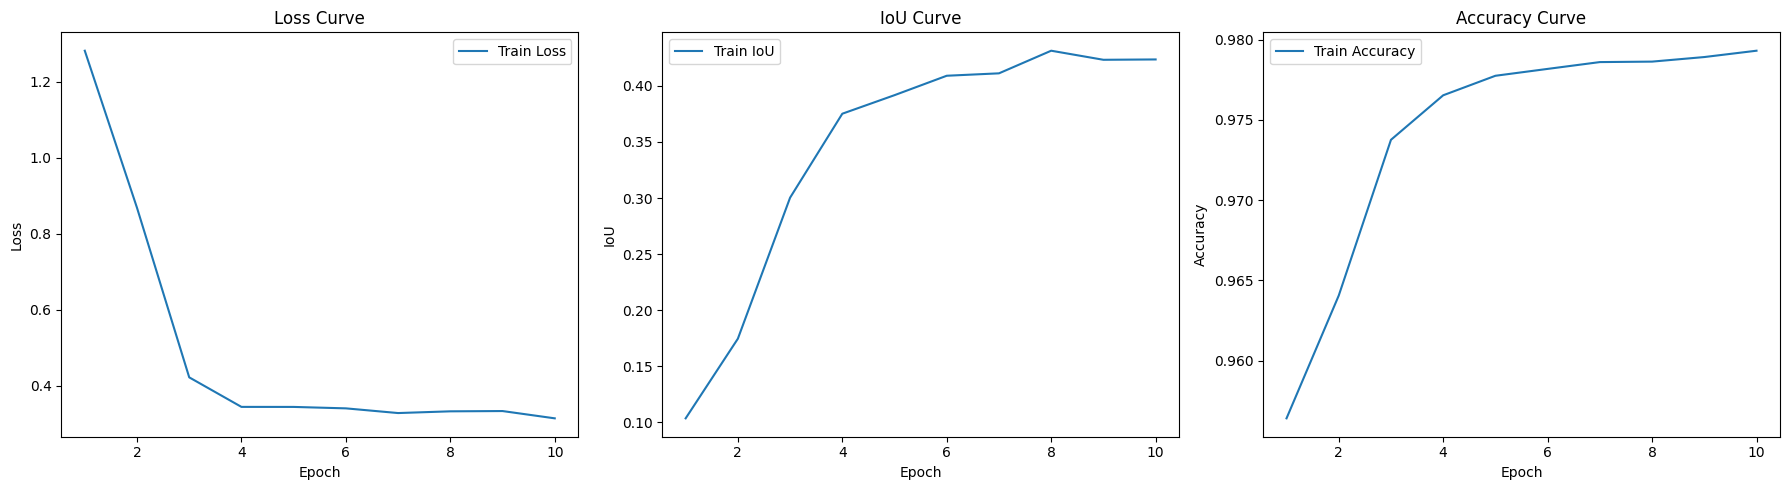

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# === Loss ===
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    smooth = 1e-6
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    true_pos = (y_true * y_pred).sum()
    false_neg = ((1 - y_true) * y_pred).sum()
    false_pos = (y_true * (1 - y_pred)).sum()

    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    ce_loss = F.binary_cross_entropy(torch.sigmoid(y_pred), y_true, reduction='none')
    focal_modulating_factor = torch.pow(1 - torch.sigmoid(y_pred), gamma)
    loss = alpha * focal_modulating_factor * ce_loss

    return loss.mean()

def combined_loss(y_true, y_pred, current_iou,
                  lambda1_base=1.0, lambda2_base=1.0):
    alpha_t = 0.7 + (0.7 - current_iou) * 0.2
    beta_t  = 0.3 - (0.7 - current_iou) * 0.2
    gamma_f = 2.0 + (0.7 - current_iou) * 1.5
    alpha_f = 0.25 + (0.7 - current_iou) * 0.2
    gamma_t = 1.0 + (0.7 - current_iou) * 3.0
    lambda1 = lambda1_base + (0.7 - current_iou) * 2.0
    lambda2 = lambda2_base + (0.7 - current_iou) * 1.5

    criterion_bce = nn.BCEWithLogitsLoss()

    bce = criterion_bce(y_pred, y_true)
    focal = focal_loss(y_true, y_pred, gamma=gamma_f, alpha=alpha_f)
    tversky = tversky_loss(y_true, y_pred, alpha=alpha_t, beta=beta_t)

    loss = bce * (1 + lambda1 * focal) + lambda2 * torch.pow((1 - tversky), gamma_t)
    return loss

# === Метрики ===
def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection / union).item() if union > 0 else 1.0

def calculate_accuracy(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).sum()
    total = target.numel()
    return (correct / total).item()

# === Обучение ===
def train_model(model, train_loader, num_epochs=10, lr=0.001, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_ious, train_accuracies = [], [], []
    current_iou = 0.0  # Стартовое значение

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_iou, epoch_accuracy = 0, 0, 0

        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)

            loss = combined_loss(masks, outputs, current_iou=current_iou)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds = torch.sigmoid(outputs)
                iou = calculate_iou(preds, masks)
                accuracy = calculate_accuracy(preds, masks)

            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_accuracy += accuracy

            if i % 10 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")

        avg_loss = epoch_loss / len(train_loader)
        avg_iou = epoch_iou / len(train_loader)
        avg_accuracy = epoch_accuracy / len(train_loader)

        current_iou = avg_iou  # Обновляем для следующей эпохи

        train_losses.append(avg_loss)
        train_ious.append(avg_iou)
        train_accuracies.append(avg_accuracy)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, IoU={avg_iou:.4f}, Accuracy={avg_accuracy:.4f}")

    # === Графики ===
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), train_ious, label="Train IoU")
    plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.title("IoU Curve"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()

    plt.tight_layout()
    plt.show()

    torch.save(model.state_dict(), "u-net-dynamicloss.pth")

num_epochs = 10
learning_rate = 1e-4
train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="cuda")

In [14]:
BATCH_SIZE = 8
NUM_WORKERS = 2
test_dataset = MultiChannelSingleMaskDataset(test_images_path, test_masks_path, img_size=512)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True) #, drop_last=True, shuffle=True

Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']


In [15]:
import numpy as np
from sklearn.metrics import average_precision_score

def calculate_metrics_binary(preds, labels):
    preds_sigmoid = torch.sigmoid(preds)
    preds_bin = (preds_sigmoid > 0.5).float()  # [B, 1, H, W] -> бинаризация
    preds_bin = preds_bin.squeeze(1)
    labels = labels.squeeze(1)

    intersection = ((preds_bin == 1) & (labels == 1)).sum(dim=(1, 2)).float()
    union = ((preds_bin == 1) | (labels == 1)).sum(dim=(1, 2)).float()
    dice = (2 * intersection) / ((preds_bin == 1).sum(dim=(1, 2)).float() + (labels == 1).sum(dim=(1, 2)).float() + 1e-8)
    iou = intersection / (union + 1e-8)

    # mAP по фиксированному порогу
    aps = []
    for i in range(preds_bin.shape[0]):
        pred_flat = preds_bin[i].flatten().detach().cpu().numpy()
        label_flat = labels[i].flatten().detach().cpu().numpy()
        if label_flat.sum() > 0:
            ap = average_precision_score(label_flat, pred_flat)
            aps.append(ap)

    return iou.mean().item(), dice.mean().item(), np.mean(aps) if aps else float('nan')


# Подсчёт метрик после обучения
model.eval()
ious, dices, maps = [], [], []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to("cuda")
        masks = masks.to("cuda").unsqueeze(1).float()

        outputs = model(images)
        iou, dice, ap = calculate_metrics_binary(outputs, masks)

        if not np.isnan(iou):
            ious.append(iou)
        if not np.isnan(dice):
            dices.append(dice)
        if not np.isnan(ap):
            maps.append(ap)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
mean_ap = np.mean(maps)

print("=== Evaluation Metrics (Defect class) ===")
print(f"IoU:  {mean_iou:.4f}")
print(f"Dice: {mean_dice:.4f}")
print(f"mAP:  {mean_ap:.4f}")


=== Evaluation Metrics (Defect class) ===
IoU:  0.6024
Dice: 0.7208
mAP:  0.5974


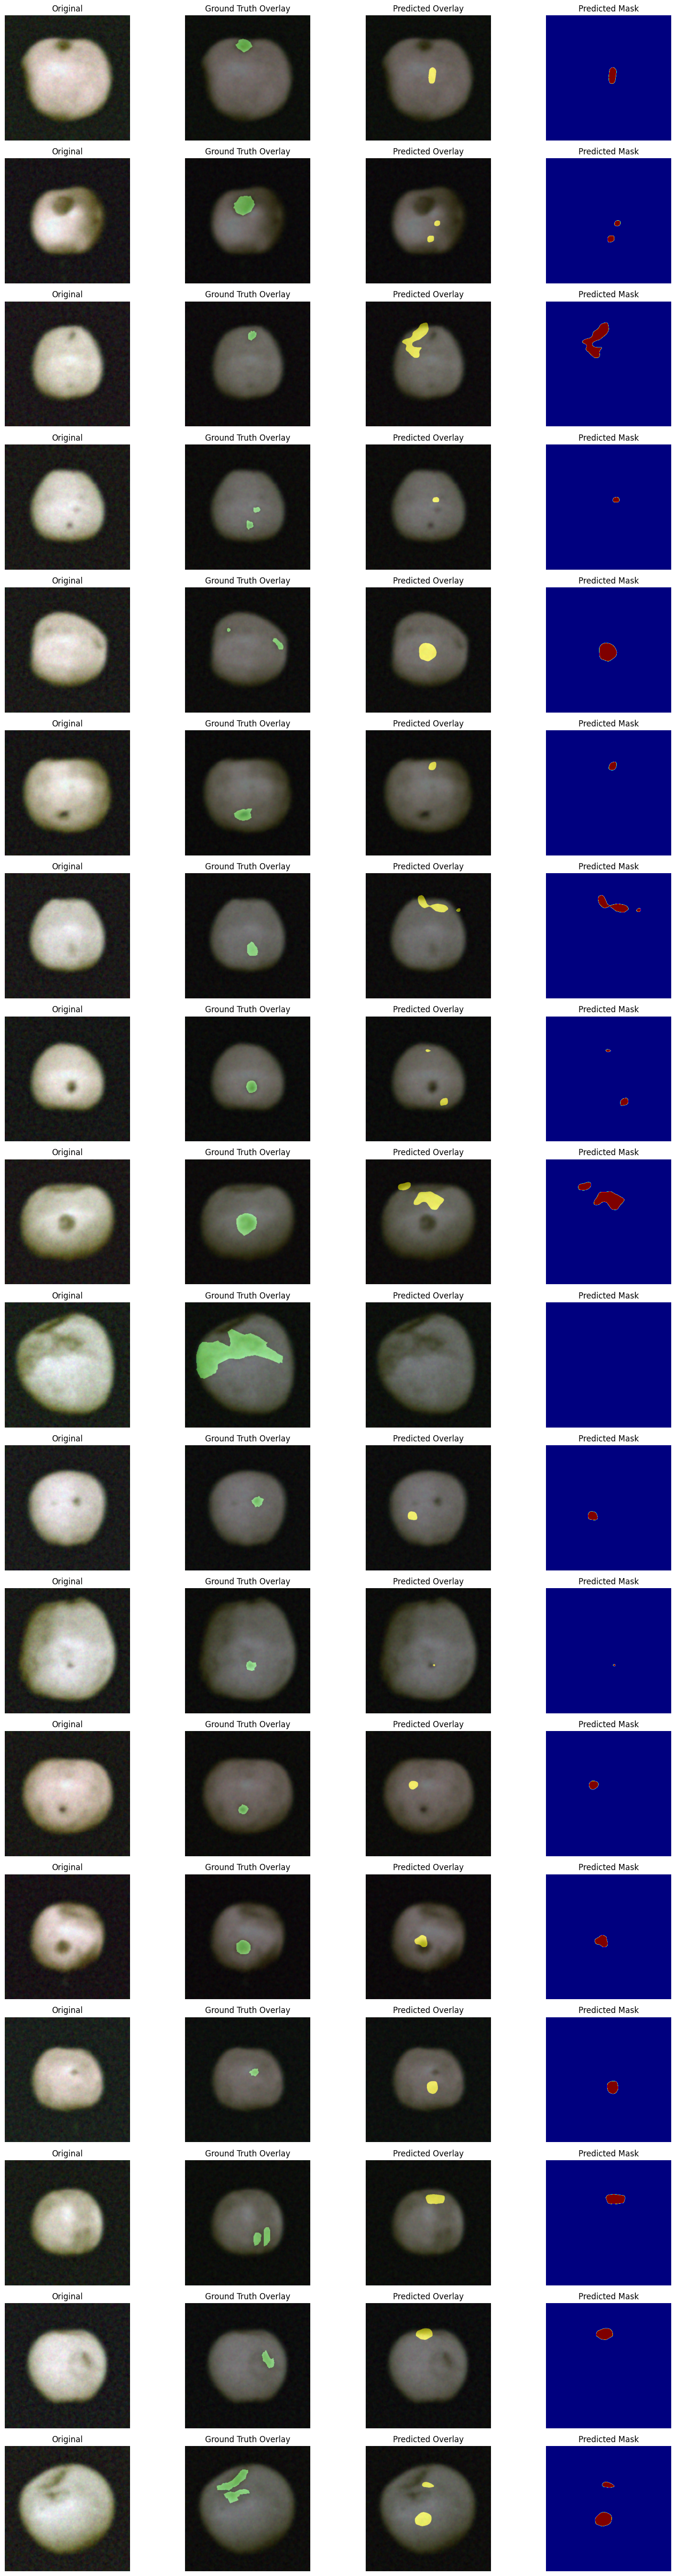

In [16]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    if len(mask.shape) == 3:
        mask = mask.squeeze()  # [1, H, W] → [H, W]

    colored_mask = np.zeros_like(image)
    for i in range(3):
        colored_mask[:, :, i] = mask * color[i]

    overlay = cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)
    return overlay

def visualize_predictions(test_loader, predictions, num_samples=10):
    predictions = [pred.squeeze().cpu().numpy() if torch.is_tensor(pred) else pred for pred in predictions]
    samples = random.sample(range(len(predictions)), min(num_samples, len(predictions)))

    fig, axes = plt.subplots(len(samples), 4, figsize=(16, len(samples) * 3))
    if len(samples) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        mask = mask.numpy().squeeze()
        pred_mask = predictions[idx]

        pred_mask = pred_mask.squeeze()
        mask = mask.squeeze()

        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        mask_binary = (mask > 0.5).astype(np.uint8)

        # Apply mask overlays
        image_uint8 = (image * 255).astype(np.uint8)
        overlay_pred = apply_mask(image_uint8, pred_binary, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask(image_uint8, mask_binary, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Overlay")

        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Overlay")

        axes[i, 3].imshow(pred_binary, cmap='jet')
        axes[i, 3].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


#  Генерация предсказаний 
model.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to("cuda")
        outputs = model(images)  # <-- если model(...) возвращает просто logits
        preds = torch.sigmoid(outputs)  # преобразование в [0, 1]
        predictions.extend(preds.cpu())

# Визуализация
visualize_predictions(test_loader, predictions, num_samples=18)


In [17]:
import random
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate
from torch.utils.data import DataLoader
import numpy as np

def generate_random_tta():
    """Случайная комбинация горизонтального и вертикального флипа"""
    return Compose([
        HorizontalFlip(p=random.choice([0.0, 1.0])),
        VerticalFlip(p=random.choice([0.0, 1.0])),
        Rotate(limit=45, p=1.0)
    ])

# Создание датасетов с разными TTA-трансформами
tta_datasets = []
for i in range(5):
    tta_transform = generate_random_tta()
    dataset = MultiChannelSingleMaskDataset(
        test_images_path,
        test_masks_path,
        img_size=512,
        transform=tta_transform
    )
    tta_datasets.append(dataset)

Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
Найдены следующие ID изображений: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031',

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [18]:
# Подсчёт метрик по всем TTA
all_ious, all_dices, all_maps = [], [], []

model.eval()
with torch.no_grad():
    for idx, dataset in enumerate(tta_datasets):
        print(f"TTA iteration {idx + 1}/{len(tta_datasets)}")
        loader = DataLoader(dataset, batch_size=4, num_workers=4)

        ious, dices, maps = [], [], []

        for images, masks in loader:
            if images is None or masks is None:
                continue  # Пропускаем битые данные

            images = images.to("cuda")
            masks = masks.to("cuda").unsqueeze(1).float()  # [B, 1, H, W]

            outputs = model(images)
            iou, dice, ap = calculate_metrics_binary(outputs, masks)

            if not np.isnan(iou):
                ious.append(iou)
            if not np.isnan(dice):
                dices.append(dice)
            if not np.isnan(ap):
                maps.append(ap)

        all_ious.append(np.mean(ious))
        all_dices.append(np.mean(dices))
        all_maps.append(np.mean(maps))

#агрегация метрик
mean_iou = np.mean(all_ious)
mean_dice = np.mean(all_dices)
mean_ap = np.mean(all_maps)

std_iou = np.std(all_ious)
std_dice = np.std(all_dices)
std_ap = np.std(all_maps)

print("\n Aggregated metrics over TTA:")
print(f"IoU (defect): {mean_iou:.4f} ± {std_iou:.4f}")
print(f"Dice (defect): {mean_dice:.4f} ± {std_dice:.4f}")
print(f"mAP (defect): {mean_ap:.4f} ± {std_ap:.4f}")

TTA iteration 1/5
TTA iteration 2/5
TTA iteration 3/5
TTA iteration 4/5
TTA iteration 5/5

 Aggregated metrics over TTA:
IoU (defect): 0.5968 ± 0.0147
Dice (defect): 0.7249 ± 0.0132
mAP (defect): 0.5920 ± 0.0144
